In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math
%matplotlib inline

import sys
sys.path.append('../')
from core.networks import BayesianNetwork as BN
from bayes_layer import BayesianConv2D
from bayes_layer import BayesianLinear
from bayes_layer import _calculate_fan_in_and_fan_out

In [2]:
def compute_conv_output_size(Lin,kernel_size,stride=1,padding=0,dilation=1):
    return int(np.floor((Lin+2*padding-dilation*(kernel_size-1)-1)/float(stride)+1))

In [3]:
class BayesianConvNetwork(nn.Module):
    def __init__(self, inputsize, taskcla, FC_ratio = 0.5, CNN_ratio = 0.25):
        super().__init__()
        
        ncha,size,_=inputsize
        self.taskcla = taskcla
        
        self.conv1 = BayesianConv2D(ncha,32,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(size,3, padding=1) # 32
        self.conv2 = BayesianConv2D(32,32,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 32
        s = s//2 # 16
        self.conv3 = BayesianConv2D(32,64,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 16
        self.conv4 = BayesianConv2D(64,64,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 16
        s = s//2 # 8
        self.conv5 = BayesianConv2D(64,128,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 8
        self.conv6 = BayesianConv2D(128,128,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 8
        self.conv7 = BayesianConv2D(128,128,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 8
        s = s//2 # 4
        self.fc1 = BayesianLinear(s*s*128,256, ratio = CNN_ratio)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        self.MaxPool = torch.nn.MaxPool2d(2)
        
        self.last=torch.nn.ModuleList()
        
        for t,n in self.taskcla:
            self.last.append(torch.nn.Linear(256,n))
        self.relu = torch.nn.ReLU()

    def forward(self, x, sample=False):
        h=self.relu(self.conv1(x,sample))
        h=self.relu(self.conv2(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv3(h,sample))
        h=self.relu(self.conv4(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv5(h,sample))
        h=self.relu(self.conv6(h,sample))
        h=self.relu(self.conv7(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=h.view(x.shape[0],-1)
        h = self.drop2(self.relu(self.fc1(h,sample)))
        y = []
        for t,i in self.taskcla:
            y.append(self.last[t](h))
        
        return y
        

In [4]:
# class BayesianConvNetwork(nn.Module):
#     def __init__(self, inputsize, taskcla, rho_init = -4.6001):
#         super().__init__()
        
#         ncha,size,_=inputsize
#         self.taskcla = taskcla
#         self.conv1 = BayesianConv2D(ncha,32,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(size,3, padding=1) # 32
#         self.conv2 = BayesianConv2D(32,32,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 32
#         s = s//2 # 16
#         self.conv3 = BayesianConv2D(32,64,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 16
#         self.conv4 = BayesianConv2D(64,64,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 16
#         s = s//2 # 8
#         self.conv5 = BayesianConv2D(64,128,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 8
#         self.conv6 = BayesianConv2D(128,128,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 8
#         self.conv7 = BayesianConv2D(128,128,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 8
#         s = s//2 # 4
        
#         self.fc1 = BayesianLinear(s*s*128,256, rho_init = rho_init) # 2048
#         self.drop1 = nn.Dropout(0.25)
#         self.drop2 = nn.Dropout(0.5)
#         self.MaxPool = torch.nn.MaxPool2d(2)
        
#         self.last=torch.nn.ModuleList()
        
#         for t,n in self.taskcla:
#             self.last.append(torch.nn.Linear(256,n))
#         self.relu = torch.nn.ReLU()

#     def forward(self, x, sample=False):
#         h=self.relu(self.conv1(x,sample))
#         h=self.relu(self.conv2(h,sample))
#         h=self.drop1(self.MaxPool(h))
#         h=self.relu(self.conv3(h,sample))
#         h=self.relu(self.conv4(h,sample))
#         h=self.drop1(self.MaxPool(h))
#         h=self.relu(self.conv5(h,sample))
#         h=self.relu(self.conv6(h,sample))
#         h=self.relu(self.conv7(h,sample))
#         h=self.drop1(self.MaxPool(h))
#         h=h.view(x.shape[0],-1)
#         h = self.drop2(self.relu(self.fc1(h,sample)))
#         y = []
#         for t,i in self.taskcla:
#             y.append(self.last[t](h))
        
#         return y

In [5]:
def weight_channel_wise_histogram(model_name, ratio=None, std_init=None):
    cnt = 0
    sample_num = []
    taskcla = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10,10)]
    task_num = 11
#     taskcla = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10)]
#     task_num = 10
    
    model = BayesianConvNetwork((3,32,32),taskcla)
    rand_std = []
    for (_, layer) in model.named_children():
        if isinstance(layer, BayesianLinear) == False and isinstance(layer, BayesianConv2D) == False:
            continue
        out_features = layer.weight_rho.shape[0]
        
        sample_num.append(out_features)
        std_arr = np.zeros((sample_num[cnt], task_num+1))
#         std_arr = np.zeros((sample_num[cnt], task_num))
        rand_idx = np.arange(out_features)
        np.random.shuffle(rand_idx)
        rand_idx = np.sort(rand_idx[:sample_num[cnt]])
        
        if ratio is not None:
            fan_in, fan_out = _calculate_fan_in_and_fan_out(layer.weight_mu)
            if isinstance(layer, BayesianLinear):
                noise_var = (2/fan_in) * ratio
            elif isinstance(layer, BayesianConv2D):
                noise_var = (2/fan_out) * ratio
            std_init = math.sqrt(noise_var)
        
        std_arr[:,0] = np.ones(sample_num[cnt]) * std_init
        for t in range(task_num):
            model.load_state_dict(torch.load(model_name%t))
            
            std = np.log(1+np.exp(layer.weight_rho.data.cpu().numpy())).reshape((out_features))
            std = np.sort(std)
            std_arr[:,t+1] = std[rand_idx]
#             std_arr[:,t] = std[rand_idx]
            
        reg_arr = (std_init/std_arr)**2
        rand_std.append(std_arr)
#         rand_std.append(reg_arr)
        cnt += 1
        
    
    plt.figure(figsize=(21,18))
    for l in range(cnt):
#         plt.figure(figsize=(15,5))
        plt.subplot(3,3,l+1)
        
        for i in range(sample_num[l]):
            plt.plot(np.arange(task_num+1), rand_std[l][i], linestyle = '-')
#             plt.plot(np.arange(task_num), rand_std[l][i], linestyle = '-')

        fontsize = 20
        plt.xticks(np.arange(task_num+1),fontsize = fontsize)
#         plt.xticks(np.arange(task_num),fontsize = fontsize)
        plt.yticks(fontsize = 15)

        plt.xlabel('Task', fontsize = fontsize)
        if l==0:
            plt.ylabel('STD',fontsize = fontsize)
#             plt.ylabel('Strength',fontsize = fontsize)
        
#         plt.ylim(0,100)
        
        plt.title('Layer %d'%(l+1), fontsize = fontsize)
        plt.tight_layout()

#     plt.savefig('figure/histogram_layer.pdf', bbox_inches='tight')

In [6]:
def avg_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    avg_acc_arr = np.zeros(tasknum)
    for i in range(tasknum):
        avg_acc_arr[i] = np.mean(acc_arr[i][:i+1])
    
    return avg_acc_arr

In [7]:
def test_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    return acc_arr

In [13]:
UCL_upper = {}
beta_arr = [5e-3,6e-3,7e-3,8e-3]
lr_rho_arr = [1e-3,5e-3,10e-3,15e-3,20e-3]
ratio_arr = [1/2,1/4]
name = 'CIFAR10_100_split_cifar10_100_baye_0_beta_{:.7f}_ratio_{:.7f}_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'
for beta in beta_arr:
    UCL_upper[beta] = {}
    for ratio in ratio_arr:
        UCL_upper[beta][ratio] = {}
        for lr_rho in lr_rho_arr:
            UCL_upper[beta][ratio][lr_rho] = avg_acc(name.format(beta, ratio, lr_rho), tasknum=11)

[0.8204     0.77635    0.74966667 0.7529     0.74616    0.73061667
 0.72407143 0.7227875  0.72163333 0.72894    0.7265    ]


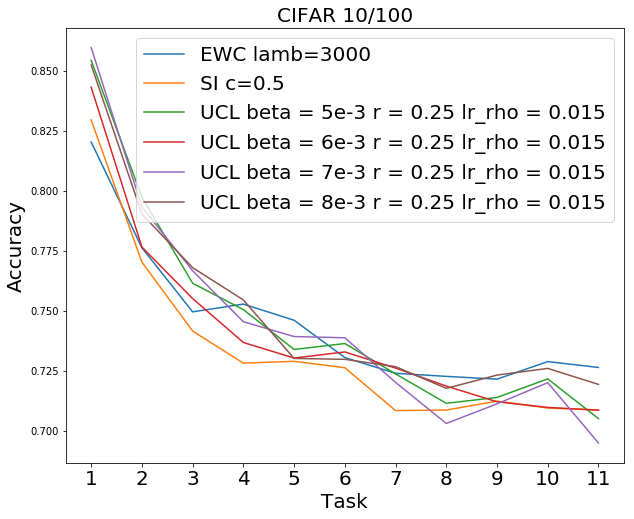

In [14]:
task = np.arange(11) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC[3000], axis = 0), linestyle='-', label='EWC lamb=3000')
plt.plot(task, np.mean(SI[0.5], axis = 0), linestyle='-', label='SI c=0.5')

ratio = 1/4
lr_rho = 15e-3


plt.plot(task, UCL_upper[5e-3][ratio][lr_rho], linestyle = '-', label = 'UCL beta = 5e-3 r = %.2f lr_rho = %.3f'%(ratio,lr_rho))
plt.plot(task, UCL_upper[6e-3][ratio][lr_rho], linestyle = '-', label = 'UCL beta = 6e-3 r = %.2f lr_rho = %.3f'%(ratio,lr_rho))
plt.plot(task, UCL_upper[7e-3][ratio][lr_rho], linestyle = '-', label = 'UCL beta = 7e-3 r = %.2f lr_rho = %.3f'%(ratio,lr_rho))
plt.plot(task, UCL_upper[8e-3][ratio][lr_rho], linestyle = '-', label = 'UCL beta = 8e-3 r = %.2f lr_rho = %.3f'%(ratio,lr_rho))



plt.xticks([1,2,3,4,5,6,7,8,9,10,11],fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.7,0.84)
# plt.yticks([0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84], fontsize = 20)
plt.title('CIFAR 10/100', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=20)

# print(np.mean(EWC[3000], axis = 0))
# print(np.mean(UCL[0.003][1/4][0.015], axis = 0))

print(np.mean(EWC[3000], axis = 0))



In [15]:
# sns.set_palette(sns.color_palette("husl", 100))

In [16]:
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0010000_ratio_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0020000_ratio_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0030000_ratio_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0040000_ratio_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0050000_ratio_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0060000_ratio_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0070000_ratio_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0080000_ratio_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)

In [17]:
UCL_alpha_5 = {}
np.zeros(1000)
name = 'alpha_results/CIFAR_100_split_cifar100_baye_0_beta_0.0000100_ratio_0.1250000_alpha_{:.2f}_lr_rho_{:.2f}_unitN_400_batch_256_epoch_100_conv.txt'
alpha_arr = np.arange(1000) / 100 + 0.01
lr_rho_arr = [0.01,0.02]
for lr_rho in lr_rho_arr:
    UCL_alpha_5[lr_rho] = np.zeros(1000)
    for i,alpha in enumerate(alpha_arr):
        UCL_alpha_5[lr_rho][i] = avg_acc(name.format(alpha, lr_rho), tasknum=10)[0]

In [18]:
UCL_alpha_4 = {}
name = 'alpha_results/CIFAR_100_split_cifar100_baye_0_beta_0.0001000_ratio_0.2500000_alpha_{:.2f}_lr_rho_{:.2f}_unitN_400_batch_256_epoch_100_conv.txt'
alpha_arr = np.arange(1000) / 100 + 0.01
ratio_arr = [1/4]
lr_rho_arr = [0.01,0.02]
for lr_rho in lr_rho_arr:
    UCL_alpha_4[lr_rho] = np.zeros(1000)
    for i,alpha in enumerate(alpha_arr):
        UCL_alpha_4[lr_rho][i] = avg_acc(name.format(alpha,lr_rho), tasknum=10)[0]

In [19]:
UCL_alpha_20 = np.zeros(1000)
name = 'alpha_results/CIFAR_100_split_cifar100_baye_0_beta_0.0001000_ratio_0.2500000_alpha_{:.2f}_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv.txt'
alpha_arr = np.arange(1000) / 100 + 0.01
for i,alpha in enumerate(alpha_arr):
    UCL_alpha_20[i] = avg_acc(name.format(alpha), tasknum=10)[0]

In [20]:
UCL_alpha = {}
name = 'alpha_results/CIFAR_100_drop_split_cifar100_baye_0_beta_0.0000100_ratio_{:.7f}_alpha_{:.2f}_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'
# ratio_arr = [1/4,1/8,1/16]
ratio_arr = [1/4,1/8,1/16]
lr_rho_arr = [1e-3,5e-3,10e-3,20e-3]
alpha_arr = np.arange(1000) / 100 + 0.01

for ratio in ratio_arr:
    UCL_alpha[ratio] = {}
    for lr_rho in lr_rho_arr:
        UCL_alpha[ratio][lr_rho] = np.zeros(1000)
        for i,alpha in enumerate(alpha_arr):
            UCL_alpha[ratio][lr_rho][i] = avg_acc(name.format(ratio,alpha,lr_rho), tasknum=10)[0]


FileNotFoundError: [Errno 2] No such file or directory: 'alpha_results/CIFAR_100_drop_split_cifar100_baye_0_beta_0.0000100_ratio_0.0625000_alpha_0.57_lr_rho_0.01_unitN_400_batch_256_epoch_100_conv.txt'

In [ ]:
UCL_CIFAR10_alpha = {}

name = 'alpha_results/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0010000_ratio_0.2500000_alpha_{:.2f}_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'

lr_rho_arr = [5e-3,10e-3,15e-3,20e-3]
alpha_arr = np.arange(10) + 1

for lr_rho in lr_rho_arr:
    UCL_CIFAR10_alpha[lr_rho] = np.zeros(10)
    for i,alpha in enumerate(alpha_arr):
        UCL_CIFAR10_alpha[lr_rho][i] = avg_acc(name.format(alpha,lr_rho), tasknum=11)[0]


In [ ]:
UCL_fixed_alpha = np.zeros(20)

name = 'alpha_results/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0010000_ratio_0.2500000_alpha_{:.2f}_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv.txt'

alpha_arr = np.arange(20)/20 + 0.05

for i,alpha in enumerate(alpha_arr):
    UCL_fixed_alpha[i] = avg_acc(name.format(alpha), tasknum=11)[0]

In [ ]:


plt.figure(figsize=(10,8))


# plt.plot(alpha_arr, UCL_alpha_5[0.01], linestyle='-', label='UCL beta=1e-5 lr = 0.01 ratio = 1/8')
# plt.plot(alpha_arr, UCL_alpha_5[0.02], linestyle='-', label='UCL beta=1e-5 lr = 0.02 ratio = 1/8')
# plt.plot(alpha_arr, UCL_alpha_4[0.01], linestyle='-', label='UCL beta=1e-4 lr = 0.01 ratio = 1/4')
# plt.plot(alpha_arr, UCL_alpha_4[0.02], linestyle='-', label='UCL beta=1e-4 lr = 0.02 ratio = 1/4')

# plt.plot(alpha_arr, UCL_alpha[1/4][1e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.001 ratio = 1/4')
# plt.plot(alpha_arr, UCL_alpha[1/4][5e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.005 ratio = 1/4')
# plt.plot(alpha_arr, UCL_alpha[1/4][10e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.01 ratio = 1/4')
# plt.plot(alpha_arr, UCL_alpha[1/4][20e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.02 ratio = 1/4')

# plt.plot(alpha_arr, UCL_alpha[1/8][1e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.001 ratio = 1/8')
# plt.plot(alpha_arr, UCL_alpha[1/8][5e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.005 ratio = 1/8')
# plt.plot(alpha_arr, UCL_alpha[1/8][10e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.01 ratio = 1/8')
# plt.plot(alpha_arr, UCL_alpha[1/8][20e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.02 ratio = 1/8')

# plt.plot(alpha_arr, UCL_alpha[1/16][1e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.001 ratio = 1/16')
# plt.plot(alpha_arr, UCL_alpha[1/16][5e-3], linestyle='-', label='UCL_drop beta=1e-5 lr = 0.005 ratio = 1/16')

# plt.plot(alpha_arr, UCL_CIFAR10_alpha[5e-3], linestyle='-', label=r'UCL $\beta$=1e-3 lr = 5e-3 r = 1/4')
# plt.plot(alpha_arr, UCL_CIFAR10_alpha[10e-3], linestyle='-', label=r'UCL $\beta$=1e-3 lr = 10e-3 r = 1/4')
# plt.plot(alpha_arr, UCL_CIFAR10_alpha[15e-3], linestyle='-', label=r'UCL $\beta$=1e-3 lr = 15e-3 r = 1/4')
# plt.plot(alpha_arr, UCL_CIFAR10_alpha[20e-3], linestyle='-', label=r'UCL $\beta$=1e-3 lr = 20e-3 r = 1/4')

plt.plot(alpha_arr, UCL_fixed_alpha, linestyle='-', marker='*', label=r'UCL $\beta$=1e-3 lr = 20e-3 r = 1/4')

# plt.xlim(0,10)
plt.xticks(alpha_arr,fontsize = 10)

plt.xlabel('Alpha', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.7,0.84)
# plt.yticks([0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84], fontsize = 20)
# plt.title('CIFAR 10/100', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=20)


# print(np.argmax(UCL_alpha_5[0.01]))
# print(np.max(UCL_alpha_5[0.01]))
# print(np.argmax(UCL_alpha_5[0.02]))
# print(np.max(UCL_alpha_5[0.02]))
# print(np.argmax(UCL_alpha_4[0.01]))
# print(np.max(UCL_alpha_4[0.01]))
# print(np.argmax(UCL_alpha_4[0.02]))
# print(np.max(UCL_alpha_4[0.02]))

# print(np.argmax(UCL_alpha[1/4][20e-3]))
# print(np.max(UCL_alpha[1/4][20e-3]))
# print(np.mean(UCL_alpha_4[0.02][600:]))

print(np.argmax(UCL_fixed_alpha))

In [ ]:
# sns.set_palette(sns.color_palette("husl", 100))

In [ ]:
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0030000_FC_0.2500000_CNN_0.2500000_lr_rho_0.015_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)

In [ ]:
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0030000_FC_0.2500000_CNN_0.2500000_lr_rho_0.016_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)

In [ ]:
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0030000_FC_0.2500000_CNN_0.2500000_lr_rho_0.015_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)

In [ ]:
# name = '../models/trained_model/CIFAR_100_split_cifar100_baye_0_beta_0.0020000_FC_0.2500000_CNN_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)